# Task 4: Demonstrating Quantum Advantage

In [80]:
"""
This task is intentionally open-ended, so no boilerplate code is provided.

You may use this notebook to develop your solution, or create a separate file if you prefer.
We recommend starting by copying over your previous implementations of the QRNG, TRNG, and PRNG.
Then, explore ways to modularize and combine these components to design a use case that
demonstrates the unique advantages of quantum randomness.

Your write-up can be included directly in this notebook or submitted separately.
You're welcome to prepare it as a Google Doc or LaTeX document and upload a PDF to the GitHub repository—
just be sure to clearly indicate where it can be found if it's not included here.
"""

"\nThis task is intentionally open-ended, so no boilerplate code is provided.\n\nYou may use this notebook to develop your solution, or create a separate file if you prefer.\nWe recommend starting by copying over your previous implementations of the QRNG, TRNG, and PRNG.\nThen, explore ways to modularize and combine these components to design a use case that\ndemonstrates the unique advantages of quantum randomness.\n\nYour write-up can be included directly in this notebook or submitted separately.\nYou're welcome to prepare it as a Google Doc or LaTeX document and upload a PDF to the GitHub repository—\njust be sure to clearly indicate where it can be found if it's not included here.\n"

In [81]:
%pip install requests
%pip install numpy
%pip install matplotlib
%pip install pyaudio
%pip install psutil
%pip install pandas
%pip install seaborn
%pip install scipy
%pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [82]:
# Package Imports - feel free to add what you think might be useful! 
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.stats import kstest, laplace
# from ucimlrepo import fetch_ucirepo
import hashlib
import struct
import psutil
import platform
import math
import pandas as pd
import seaborn as sns

In [83]:
def get_qrng_floats(n, min_val=0.0, max_val=1.0):
    url = "https://qrng.idqloud.com/api/1.0/double"
    headers = {"X-API-KEY": "aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"}
    max_chunk = 16
    results = []
    
    # Split requests into chunks
    for _ in range(n // max_chunk):
        response = requests.get(
            url,
            headers=headers,
            params={
                "min": str(min_val),
                "max": str(max_val),
                "quantity": str(max_chunk)
            }
        )
        response.raise_for_status()
        results.extend(response.json()['data'])
    
    # Handle remaining numbers
    remaining = n % max_chunk
    if remaining > 0:
        response = requests.get(
            url,
            headers=headers,
            params={
                "min": str(min_val),
                "max": str(max_val),
                "quantity": str(remaining)
            }
        )
        response.raise_for_status()
        results.extend(response.json()['data'])
    
    return np.array(results, dtype=np.float64)

In [84]:
def get_laplace_transform(P, epsilon):
    # P is the scaled random numbers from get_qrng_floats()
    # Epsilon is the threshold for privacy (smaller epsilon = more privacy = less utility)
    b = 1 / epsilon
    laplace = []
    for p in P:
        if p == 0:
            laplace.append(float('-inf'))
        elif p < 0.5:
            laplace.append(b * math.log(2 * p))
        else:
            laplace.append(-b * math.log(2 * (1 - p)))
    return laplace

In [85]:
random_numbers = get_qrng_floats(40)
print(random_numbers)


[0.22631362 0.74642476 0.22739373 0.74221421 0.92318575 0.56928073
 0.7008838  0.15443111 0.42500869 0.97405986 0.77836394 0.32902229
 0.58850081 0.03338324 0.71409697 0.63680091 0.3972757  0.71940573
 0.76778465 0.15713372 0.92429186 0.91861711 0.10607227 0.88469361
 0.46238273 0.87267194 0.6819358  0.83466324 0.71591831 0.80238614
 0.29711392 0.15282969 0.65709735 0.01441342 0.13844001 0.7089765
 0.79080681 0.30260606 0.76828176 0.89189412]


In [86]:
epsilon = 0.25
laplace_transform = get_laplace_transform(random_numbers, epsilon)

In [87]:
size = 20

changes = -np.random.poisson(2, size)
positive = 324 + np.maximum.reduce([changes, np.random.normal(0, 4, size).astype(int)]).cumsum()
total = 100000 + changes.cumsum()

In [88]:
hiv_df = pd.DataFrame(np.array([positive, total]).T, columns=["Positive", "Total"])
hiv_df.index = range(2000, 2020)

In [89]:
hiv_df["Percent"] = hiv_df["Positive"] / hiv_df["Total"]

In [90]:
display(hiv_df)

,Positive,Total,Percent
2000,325,99998,0.003250
2001,325,99998,0.003250
2002,327,99993,0.003270
2003,327,99993,0.003270
2004,325,99991,0.003250
2005,327,99988,0.003270
2006,327,99988,0.003270
2007,323,99982,0.003231
2008,321,99980,0.003211
2009,322,99980,0.003221


In [91]:
hiv_df_differential_privacy = hiv_df.copy(deep=True)
hiv_df_differential_privacy["Positive"] = hiv_df["Positive"] + np.array(laplace_transform[:20]).astype(int)
hiv_df_differential_privacy["Total"] = hiv_df["Total"] + np.array(laplace_transform[20:]).astype(int)
hiv_df_differential_privacy["Percent"] = hiv_df_differential_privacy["Positive"] / hiv_df_differential_privacy["Total"]

display(hiv_df_differential_privacy)

,Positive,Total,Percent
2000,322,100005,0.003220
2001,327,100005,0.003270
2002,324,99987,0.003240
2003,329,99998,0.003290
2004,332,99991,0.003320
2005,327,99993,0.003270
2006,329,99989,0.003290
2007,319,99986,0.003190
2008,321,99982,0.003211
2009,333,99983,0.003331


In [92]:
hiv_df.to_csv("hiv_data.csv", index=True)
hiv_df_differential_privacy.to_csv("hiv_data_dp.csv", index=True)

In [93]:
hiv_df = pd.read_csv("hiv_data.csv", index_col=0)
hiv_df_differential_privacy = pd.read_csv("hiv_data_dp.csv", index_col=0)

In [94]:
# Calculate IQR for the 'Positive' column
q1 = hiv_df['Positive'].quantile(0.25)
q3 = hiv_df['Positive'].quantile(0.75)
iqr = q3 - q1

# Define bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out rows with outliers in the 'Positive' column
filtered_hiv_df = hiv_df[(hiv_df['Positive'] >= lower_bound) & (hiv_df['Positive'] <= upper_bound)]
filtered_hiv_df_differential_privacy = hiv_df_differential_privacy.loc[filtered_hiv_df.index]

# Recalculate correlation after removing outliers
positive_corr = np.corrcoef(filtered_hiv_df['Positive'], filtered_hiv_df_differential_privacy['Positive'])[0, 1]
total_corr = np.corrcoef(hiv_df['Total'], hiv_df_differential_privacy['Total'])[0, 1]

print(f"Correlation between Positive columns (after removing outliers): {positive_corr:.4f}")
print(f"Correlation between Total columns: {total_corr:.4f}")


Correlation between Positive columns (after removing outliers): 0.4863
Correlation between Total columns: 0.9287


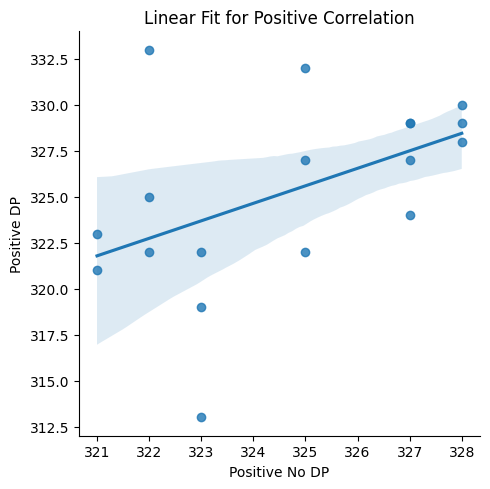

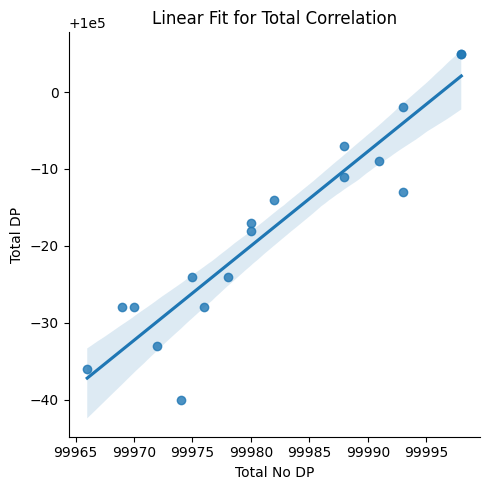

In [95]:
sns.lmplot(x='Positive No DP', y='Positive DP', data=pd.DataFrame({
    'Positive No DP': filtered_hiv_df['Positive'],
    'Positive DP': filtered_hiv_df_differential_privacy['Positive']
}))
plt.title('Linear Fit for Positive Correlation')
plt.tight_layout()
plt.show()

sns.lmplot(x='Total No DP', y='Total DP', data=pd.DataFrame({
    'Total No DP': filtered_hiv_df['Total'],
    'Total DP': filtered_hiv_df_differential_privacy['Total']
}))
plt.title('Linear Fit for Total Correlation')
plt.tight_layout()
plt.show()


(20,)


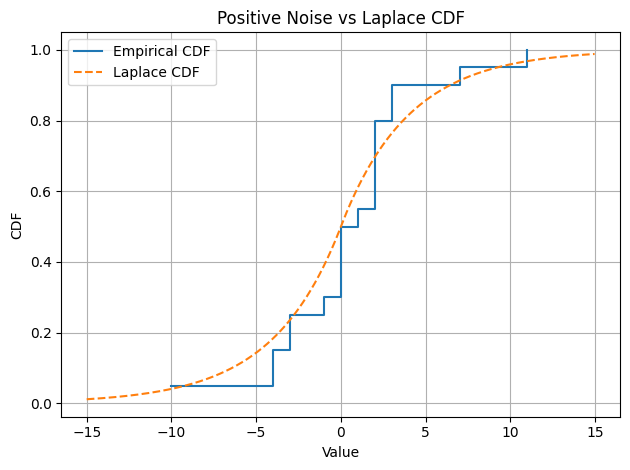

(20,)


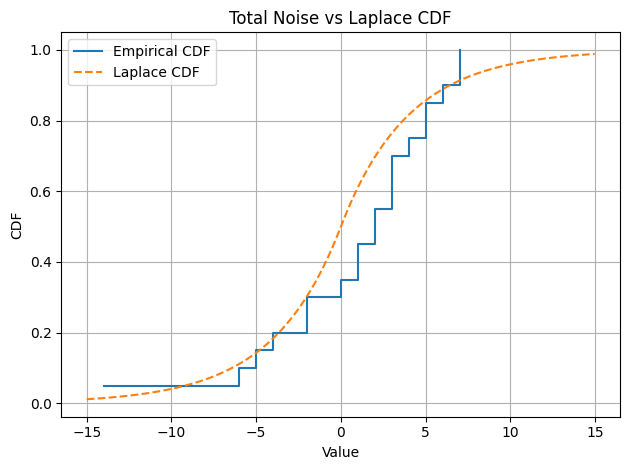

In [106]:
import matplotlib.pyplot as plt

def plot_cdf_vs_laplace(series, title):
    print(series.shape)
    data = series.dropna().values
    data.sort()

    loc = 0
    scale = 1 / epsilon

    # CDF from observed/empircal data
    ecdf = np.arange(1, len(data)+1) / len(data)
    # Theoretical CDF
    garp = (np.arange(1000) / 1000) * 30 - 15
    laplace_cdf = laplace.cdf(garp, loc=loc, scale=scale)

    plt.plot(data, ecdf, drawstyle='steps-post', label='Empirical CDF')
    plt.plot(garp, laplace_cdf, linestyle='--', label='Laplace CDF')
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cdf_vs_laplace(hiv_df_differential_privacy['Positive'] - hiv_df['Positive'], "Positive Noise vs Laplace CDF")
plot_cdf_vs_laplace(hiv_df_differential_privacy['Total'] - hiv_df['Total'], "Total Noise vs Laplace CDF")


In [97]:
columns = [
    'age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode',
    'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk', 'marital_status',
    'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin',
    'sex', 'member_of_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat',
    'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_status',
    'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat',
    'detailed_household_summary_in_household', 'instance_weight', 'migration_code_change_in_msa',
    'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18',
    'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self',
    'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin',
    'veterans_benefits', 'weeks_worked_in_year', 'year', 'income'
]
# fetch dataset 
census_income_kdd = fetch_ucirepo(id=117) 

In [98]:
df_features = census_income_kdd.data.features 
df_targets = census_income_kdd.data.targets 

# include everything BUT income
df_features.columns = columns[:-1]
# include ONLY income
df_targets.columns = [columns[-1]]

df = pd.concat([df_features, df_targets], axis=1)

print(df)

        age                  class_of_worker  detailed_industry_recode  \
0        73                  Not in universe                         0   
1        58   Self-employed-not incorporated                         4   
2        18                  Not in universe                         0   
3         9                  Not in universe                         0   
4        10                  Not in universe                         0   
...     ...                              ...                       ...   
199518   87                  Not in universe                         0   
199519   65       Self-employed-incorporated                        37   
199520   47                  Not in universe                         0   
199521   16                  Not in universe                         0   
199522   32                          Private                        42   

        detailed_occupation_recode                    education  \
0                                0         H

In [99]:
# Example: searching dataset by education level
counts = df['education'].value_counts()
print("True counts per education level:")
print(counts)

True counts per education level:
education
High school graduate                      48407
Children                                  47422
Some college but no degree                27820
Bachelors degree(BA AB BS)                19865
7th and 8th grade                          8007
10th grade                                 7557
11th grade                                 6876
Masters degree(MA MS MEng MEd MSW MBA)     6541
9th grade                                  6230
Associates degree-occup /vocational        5358
Associates degree-academic program         4363
5th or 6th grade                           3277
12th grade no diploma                      2126
1st 2nd 3rd or 4th grade                   1799
Prof school degree (MD DDS DVM LLB JD)     1793
Doctorate degree(PhD EdD)                  1263
Less than 1st grade                         819
Name: count, dtype: int64


In [100]:
n = len(counts)
random_numbers = get_qrng_floats(n)
epsilon = 0.25
laplace_noise = get_laplace_transform(random_numbers, epsilon)
privatized_counts = [max(0, count + noise) for count, noise in zip(counts.values, laplace_noise)]

In [101]:
df_plot = pd.DataFrame({
    'Category': counts.index,
    'True Count': counts.values,
    # 'Privatized Count': privatized_counts
    'Privatized Count': [int(x) for x in privatized_counts]
})

print(df_plot)

                                   Category  True Count  Privatized Count
0                      High school graduate       48407             48398
1                                  Children       47422             47423
2                Some college but no degree       27820             27822
3                Bachelors degree(BA AB BS)       19865             19863
4                         7th and 8th grade        8007              8013
5                                10th grade        7557              7565
6                                11th grade        6876              6874
7    Masters degree(MA MS MEng MEd MSW MBA)        6541              6548
8                                 9th grade        6230              6233
9       Associates degree-occup /vocational        5358              5359
10       Associates degree-academic program        4363              4363
11                         5th or 6th grade        3277              3282
12                    12th grade no di

True Counts Mean: 11736.64705882353
Privatized Counts Mean: 11738.235294117647
(17,)


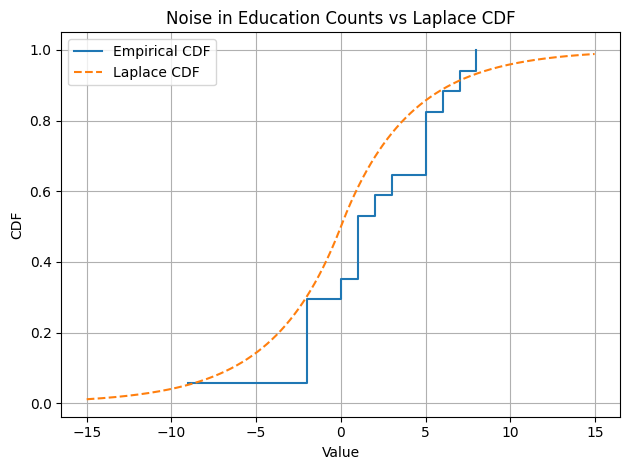

In [109]:
privatized_counts_series = pd.Series([int(x) for x in privatized_counts], index=counts.index)

print("True Counts Mean:", counts.mean())
print("Privatized Counts Mean:", privatized_counts_series.mean())


# Compute differences between privatized and true counts
differences = privatized_counts_series - counts

# Plot CDF of differences to verify noise distribution
plot_cdf_vs_laplace(differences, "Noise in Education Counts vs Laplace CDF")

In [110]:
differences = privatized_counts_series - counts
statistic, p_value = kstest(differences, 'laplace', args=(0, 4))
print(f"KS statistic = {statistic:.4f}, p-value = {p_value:.4f}")

KS statistic = 0.2577, p-value = 0.1751
